## In this notebook, I am testing the correction of TT plots involving ancient samples

In [336]:
import random
import numpy as np
import pandas as pd
import json
import sys
import os
import wbj
from math import log
import matplotlib
%matplotlib inline
# matplotlib.use('pdf')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_style('ticks')
sns.set_theme(style="whitegrid")

In [352]:
# Global toggle to save / not-save figures
isSaveFigures = True

# adjust some font params
plt.rcParams.update({'font.size': 12})
plt.rc('legend',fontsize='12')

In [338]:
# some common variables
mu=1.45e-8
gen_time=29

In [339]:
archaics = ['Neanderthal','Denisovan']
matjes = ['flo006','flo001','flo003','flo011']
ancients = ['flo006','flo001','flo003','Mota','baa001','ShumLaka','flo011']
sampling_t = [8700,7800,3620,4500,2000,8000,5650]
sampling_mu_t = [(x/gen_time)*mu for x in sampling_t]
sampling_times = dict(zip(ancients,sampling_mu_t))
moderns = ['Dai','Han','Yoruba','Mandenka','Dinka','San','French','Sardinia','Nama','Juhoansi','Xun','Karretjie']
#moderns=['Nama','Xun','Karretjie','Luhya','Mandenka','Yoruba','Sardinian','Dinka','Mende','Dinka','Biaka','French','Ju_hoan_North','Dai','Khomani_San','Han']

In [340]:
# Read in mu_err estimates from file (previously calculated using "getting_mu_err.ipynb"):
mu_err_estimates = json.load(open("mu_err_estimates.json"))

In [341]:
# mu_err_estimates with zero correction
#mu_err_estimates = {'flo006': 0.0,
# 'flo001': 0.0,
# 'flo003': 0.0,
# 'Mota': 0.0,
# 'baa001': 0.0,
# 'ShumLaka': 0.0,
# 'flo011': 0.0}

In [342]:
def sum_over_all_nt(a_d):
    m0=0
    m1=0
    m2=0
    m3=0
    m4=0
    m5=0
    m6=0
    m7=0
    m8=0
    for a_nt_c in a_d:
        nt=a_nt_c[0]
        temp=a_nt_c[2:].split(',')
        if nt in ['A','C','G','T']:
            m0+=int(temp[0])
            m1+=int(temp[1])
            m2+=int(temp[2])
            m3+=int(temp[3])
            m4+=int(temp[4])
            m5+=int(temp[5])
            m6+=int(temp[6])
            m7+=int(temp[7])
            m8+=int(temp[8])
    return (m1,m2,m3,m4,m5,m6,m7,m0+m8)


def do_inverse(in_tuple):
    (m10,m01,m20,m02,m11,m21,m12,m00)=in_tuple
    return (m01,m10,m02,m20,m11,m12,m21,m00)

def get_count_list(file_list):
    count_list=[]
    for f in file_list:
        myf=open('DIR_counts_per_5cm_TT/'+f,'r')
        for a_l in myf:
            d=a_l.split()
            counts=sum_over_all_nt(d[1:])
            if sum(counts)>0:
                count_list.append(counts)
        myf.close()
    b_list=[]
    return count_list

def get_inverse_count_list(file_list):
    count_list=[]
    for f in file_list:
        myf=open(f,'r')
        for a_l in myf:
            d=a_l.split()
            counts=sum_over_all_nt(d[1:])
            count_list.append(do_inverse(counts))
        myf.close()
    b_list=[]
    return count_list


def estimate_param(in_tuple, pop_tuple):
    (n1,n2,n3,n4,n5,n6,n7,n0)=in_tuple
    n_tot=1.0*sum(in_tuple)
    # identify ancient samples in the comparisons and retrieve relevant sampling times
    ancient_samples = list(set(ancients) & set(pop_tuple))
    mu_t = [sampling_times[x] for x in ancient_samples]    #correcting for excess singletons on ancient branch
    if len(ancient_samples)==1:
        mu_err = mu_err_estimates[ancient_samples[0]] # get the relevant mu_err estimate
        excess_singletons = n_tot*mu_err*2 # excess number of singletons on ancient branch due to damage and doubled because mu_err is for haploid
        ancient_idx = pop_tuple.index(ancient_samples[0])# find which branch the ancient sample is on
        if ancient_idx == 0: # ancient sample is on left of comparison tuple
            n1 = n1-excess_singletons # adjust the number of singletons   
        else: # ancient sample is the right branch
            n2 = n2-excess_singletons
    elif len(ancient_samples)==2: # need to remove excess singletons from both branches
        mu_err1 = mu_err_estimates[pop_tuple[0]]
        mu_err2 = mu_err_estimates[pop_tuple[1]]
        excess1 = n_tot*mu_err1*2 # excess number of singletons on ancient branch due to damage
        n1 = n1-excess1 # adjust the number of singletons
        excess2 = n_tot*mu_err2*2 
        n2 = n2-excess2 
    
    ### calculate parameters as normal
    mu_t1_t2_diff=1.0*(n3-n4+0.5*(n1+n6-n2-n7))/n_tot
    mu_t1_p1=1.0*n3+0.5*n1
    mu_t1_p2=(n5+2.0*n6)*(n5+6.0*n7)/(8.0*n5)
    mu_t1=(mu_t1_p1-mu_t1_p2)/n_tot
    mu_t2_p1=1.0*n4+0.5*n2
    mu_t2_p2=(n5+6.0*n6)*(n5+2.0*n7)/(8.0*n5)
    mu_t2=(mu_t2_p1-mu_t2_p2)/n_tot

    return [mu_t1,mu_t2,mu_t1_t2_diff]

In [343]:
def get_res(raw_data,pop_tuple):
    obs_d=[]
    for i in range(len(raw_data[0])):
        obs_d.append(0)
    for a_tuple in raw_data:
        for i in range(len(a_tuple)):
            obs_d[i]+=a_tuple[i]
    [obs_mu_t1,obs_mu_t2,obs_mu_diff_t1_t2]=estimate_param(obs_d,pop_tuple)
    l_mu_t1=[]
    l_mu_t2=[]
    l_mu_diff_t1_t2=[]

    num_sites=[]
    g=0
    n=0
    for a_t in raw_data:
        if sum(a_t)>0:
            g+=1
            n+=sum(a_t)
            local_tuple=(obs_d[0]-a_t[0],obs_d[1]-a_t[1],obs_d[2]-a_t[2],obs_d[3]-a_t[3],obs_d[4]-a_t[4],obs_d[5]-a_t[5],obs_d[6]-a_t[6],obs_d[7]-a_t[7])
            [mu_t1,mu_t2,mu_diff_t1_t2]=estimate_param(local_tuple,pop_tuple)
            l_mu_t1.append(mu_t1)
            l_mu_t2.append(mu_t2)
            l_mu_diff_t1_t2.append(mu_diff_t1_t2)
            num_sites.append(sum(a_t))

    b_res=[wbj.get_WBJ_mean_var(g,n,obs_mu_t1,l_mu_t1,num_sites)]
    b_res.append(wbj.get_WBJ_mean_var(g,n,obs_mu_t2,l_mu_t2,num_sites))
    b_res.append(wbj.get_WBJ_mean_var(g,n,obs_mu_diff_t1_t2,l_mu_diff_t1_t2,num_sites))
    return b_res

def get_estimates(file_dict):
    b_dict={}
    for a_tuple in file_dict.keys():
        print(a_tuple)
        file_list=file_dict[a_tuple]
        count_list=get_count_list(file_list)
        #print(count_list)     
        b_dict.update({a_tuple:get_res(count_list,a_tuple)})
    return b_dict

### Assign model and double check you have the results files for it

In [344]:
# build dict for each pair with a file of counts per chr
all_files_dict={}
temp=os.listdir('DIR_counts_per_5cm_TT')
for x in temp:
    if x[:len('chr')]=='chr':
        d=x.split('_')
        pop_tuple=(d[1],d[3][:-len('.txt')])
            #print(pop_tuple,d)
            #input()
        if not pop_tuple in all_files_dict.keys():
            all_files_dict.update({pop_tuple:[]})
        all_files_dict[pop_tuple].append(x)

# Double check that all 22 chrs are present for each comparison
for a_tuple in all_files_dict.keys():
    if not len(all_files_dict[a_tuple])==22:
        print(a_tuple,len(all_files_dict[a_tuple]))
        print(sorted(all_files_dict[a_tuple]))
        print('Not 22 chroms')
        input()

In [345]:
# get the subset of files for comparisons you are interested in; a given modern sample and all ancients
#all_files_dict = {k: v for k, v in all_files_dict.items() if (k[0] or k[1]) in ancients}
a_res = get_estimates(all_files_dict)

('Dai', 'Xun')
('Nama', 'Neanderthal')
('flo006', 'Denisovan')
('flo001', 'flo003')
('flo001', 'French')
('baa001', 'Neanderthal')
('flo003', 'ShumLaka')
('Mandenka', 'Juhoansi')
('baa001', 'Dai')
('flo001', 'ShumLaka')
('Mota', 'Mandenka')
('flo003', 'baa001')
('flo001', 'Nama')
('flo011', 'Xun')
('Mota', 'San')
('flo003', 'Dinka')
('flo001', 'baa001')
('Mbuti', 'Denisovan')
('flo001', 'Dai')
('Han', 'Karretjie')
('flo001', 'San')
('ShumLaka', 'Denisovan')
('Mota', 'Dinka')
('flo011', 'Denisovan')
('Dinka', 'Juhoansi')
('flo011', 'Mota')
('ShumLaka', 'Nama')
('flo011', 'Juhoansi')
('baa001', 'Nama')
('Dinka', 'Yoruba')
('Mota', 'Xun')
('baa001', 'French')
('Dai', 'Nama')
('Mbuti', 'Juhoansi')
('flo006', 'Neanderthal')
('Han', 'Xun')
('Mota', 'Dai')
('ShumLaka', 'French')
('baa001', 'Karretjie')
('Mandenka', 'San')
('flo006', 'Yoruba')
('flo003', 'French')
('Dinka', 'Dai')
('flo003', 'flo006')
('Mandenka', 'Xun')
('Mbuti', 'Karretjie')
('French', 'Han')
('flo003', 'Juhoansi')
('flo011'

In [346]:
# Construct a dataframe from results dict
res_df = pd.DataFrame.from_dict(a_res, orient='index').reset_index()
res_df.columns = ['Populations','mu_t1','mu_t2','diff_mu_t1_t2']
res_df[['mu_t1_obsmean','mu_t1_wbjmean','mu_t1_wbjvar']] = pd.DataFrame(res_df['mu_t1'].tolist(), index=res_df.index)
res_df[['mu_t2_obsmean','mu_t2_wbjmean','mu_t2_wbjvar']] = pd.DataFrame(res_df['mu_t2'].tolist(), index=res_df.index)
res_df[['diff_mu_t1_t2_obsmean','diff_mu_t1_t2_wbjmean','diff_mu_t1_t2_wbjvar']] = pd.DataFrame(res_df['diff_mu_t1_t2'].tolist(), index=res_df.index)
res_df.drop(['mu_t1', 'mu_t2','diff_mu_t1_t2'], axis=1, inplace=True)
cols = res_df.columns.drop('Populations')
res_df[cols] = res_df[cols].apply(pd.to_numeric, errors='coerce')
res_df['Populations'] = res_df['Populations'].astype("string") # edit the 'Populations' string to look nicer 
res_df['Populations'] = res_df['Populations'].str.slice_replace(stop=1, repl='')
res_df['Populations'] = res_df['Populations'].str.slice_replace(start=-1, repl='')
res_df['Populations'] = res_df['Populations'].str.replace("'", '')
# each column contains and observed mean, a wbj mean and a wbj error
# construct SE for later plotting
res_df['mu_t1_SE'] = res_df['mu_t1_wbjvar'].apply(lambda x: 2*np.sqrt(x))
res_df['mu_t2_SE'] = res_df['mu_t2_wbjvar'].apply(lambda x: 2*np.sqrt(x))
res_df['diff_mu_t1_t2_SE'] = res_df['diff_mu_t1_t2_wbjvar'].apply(lambda x: 2*np.sqrt(x))

# transform all numeric columns with mu and generation time to get years
numeric_cols = res_df.select_dtypes(exclude="string").columns
res_df[numeric_cols] = res_df[numeric_cols].apply(lambda x: x/mu * gen_time)

### Plotting functions

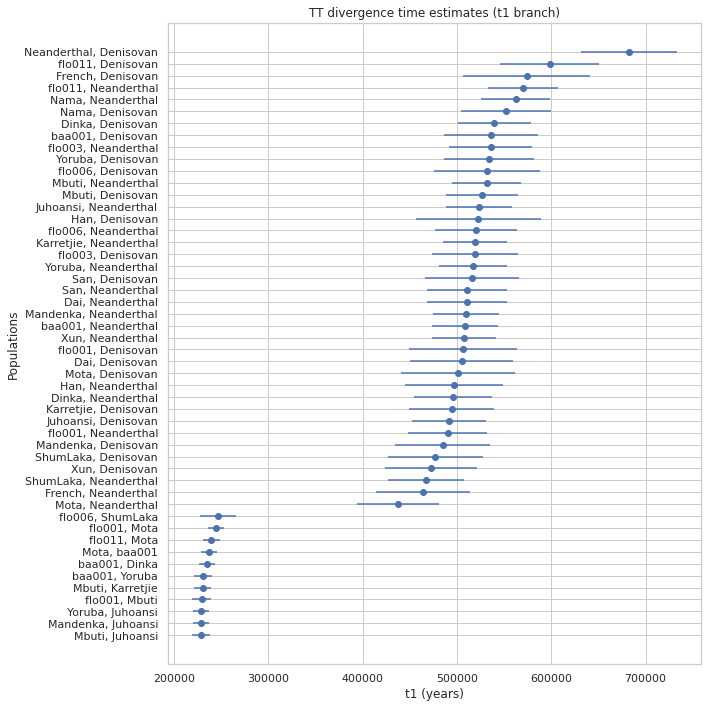

In [347]:
res_df_sorted = res_df.sort_values('mu_t1_wbjmean')

# Plot data
fig,ax = plt.subplots(1,1,figsize=(10,10))
a = res_df_sorted[-50::]['mu_t1_wbjmean']
b = res_df_sorted[-50::]['Populations']
#ax.scatter(a, b)
c = res_df_sorted[-50::]['mu_t1_SE']
ax.errorbar(a, b, xerr=c, fmt='o')
ax.ticklabel_format(style='plain', axis='x')
ax.set_xlabel('t1 (years)')
ax.set_ylabel('Populations')
ax.set_title('TT divergence time estimates (t1 branch)')
plt.tight_layout()
if isSaveFigures:
    plt.savefig('figures/TT_mu_t1.pdf')

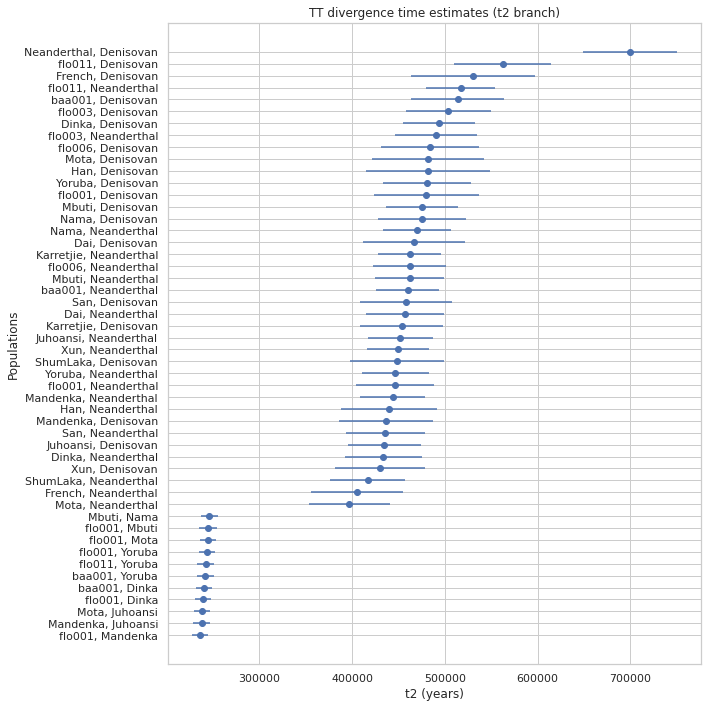

In [348]:
# Sort by t2
res_df_sorted = res_df_sorted.sort_values('mu_t2_wbjmean')

fig,ax = plt.subplots(1,1,figsize=(10,10))
a = res_df_sorted[-50::]['mu_t2_wbjmean']
b = res_df_sorted[-50::]['Populations']
#ax.scatter(a, b)
c = res_df_sorted[-50::]['mu_t2_SE']
ax.errorbar(a, b, xerr=c, fmt='o')
ax.ticklabel_format(style='plain', axis='x')
ax.set_xlabel('t2 (years)')
ax.set_ylabel('Populations')
ax.set_title('TT divergence time estimates (t2 branch)')
plt.tight_layout()
if isSaveFigures:
    plt.savefig('figures/TT_mu_t2_uncorrected_zoom.pdf')

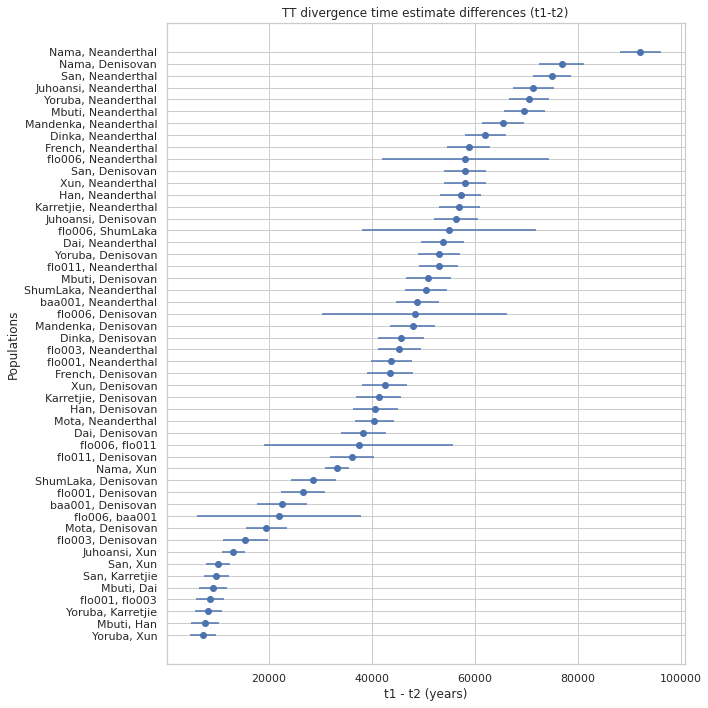

In [349]:
# Sort by time difference
res_df_sorted = res_df_sorted.sort_values('diff_mu_t1_t2_wbjmean')

fig,ax = plt.subplots(1,1,figsize=(10,10))
a = res_df_sorted[-50::]['diff_mu_t1_t2_wbjmean']
b = res_df_sorted[-50::]['Populations']
#ax.scatter(a, b)
c = res_df_sorted[-50::]['diff_mu_t1_t2_SE']
ax.errorbar(a, b, xerr=c, fmt='o')
ax.ticklabel_format(style='plain', axis='x')
ax.set_xlabel('t1 - t2 (years)')
ax.set_ylabel('Populations')
ax.set_title("TT divergence time estimate differences (t1-t2)")
plt.tight_layout()
if isSaveFigures:
    plt.savefig('figures/TT_mu_t_diff_uncorrected_zoom.pdf')

In [350]:
# Apply custom function to return a 1 or 2 based on which name has higher coverage, and its position in the tuple
# Get population
def get_HighCovPop(in_tuple):
    '''
    Function to take a string of populations, find the higher coverage population and return 1 | 2 based on which branch is higher coverage
    '''
    pop1, pop2 = in_tuple.split(", ") # get pops from input string
    pop1_idx = pops_by_cov.index(pop1)
    pop2_idx = pops_by_cov.index(pop2)
    if pop1_idx > pop2_idx:
        return 1
    elif pop1_idx < pop2_idx:
        return 2
    else:
        raise ValueError("Populations not being found as expected")


pops_by_cov=['flo006','flo001','flo003','Mota','baa001','ShumLaka','flo011','Nama','Juhoansi','Xun','Karretjie','Neanderthal','Denisovan','Dai','Han','Yoruba','Mandenka','Dinka','San','Mbuti','French','Sardinia']
#pops_by_cov=['flo006','flo001','flo003','Mota','baa001','ShumLaka','flo011','Nama','Xun','Karretjie','Neanderthal','Denisovan','Luhya','Mandenka','Yoruba','Sardinian','Dinka','Mende','Dinka','Biaka','French','Ju_hoan_North','Dai','Khomani_San','Han']

res_df['HighCovPop'] = res_df['Populations'].apply(get_HighCovPop)

# Create new columns of higher coverage branch times and wbjvar
res_df['HighCovBranch_wbjmeanT'] = np.where(res_df['HighCovPop']==1, res_df['mu_t1_wbjmean'], res_df['mu_t2_wbjmean'])
res_df['HighCovBranch_SE_T'] = np.where(res_df['HighCovPop']==1, res_df['mu_t1_SE'], res_df['mu_t2_SE'])

In [412]:
# Save Pandas dataframe down to file
res_df.to_csv('DIR_estimates/TT_results.csv', index=False)

In [ ]:
res_df_sorted = res_df.sort_values('HighCovBranch_wbjmeanT')

In [406]:
# 3) Some custom filters for subsetting dataframe to only comparisons you care about
def get_FilterMatjesPops(in_tuple):
    '''
    Function to take a string of populations, check if populations exist in a list population and return 1 | 2 based on which branch is higher coverage
    '''
    pop1, pop2 = in_tuple.split(", ") # get pops from input string
    return (pop1 or pop2) in matjes

def get_FilterAncientPops(in_tuple):
    pop1, pop2 = in_tuple.split(", ") # get pops from input string
    return (pop1 or pop2) in ancients

def get_FilterModernPops(in_tuple):
    pop1, pop2 = in_tuple.split(", ") # get pops from input string
    return set([pop1,pop2]).issubset(set(moderns))

In [371]:
mask_ancients = res_df_sorted['Populations'].apply(get_FilterAncientPops)
df_ancients = res_df_sorted[mask_ancients]

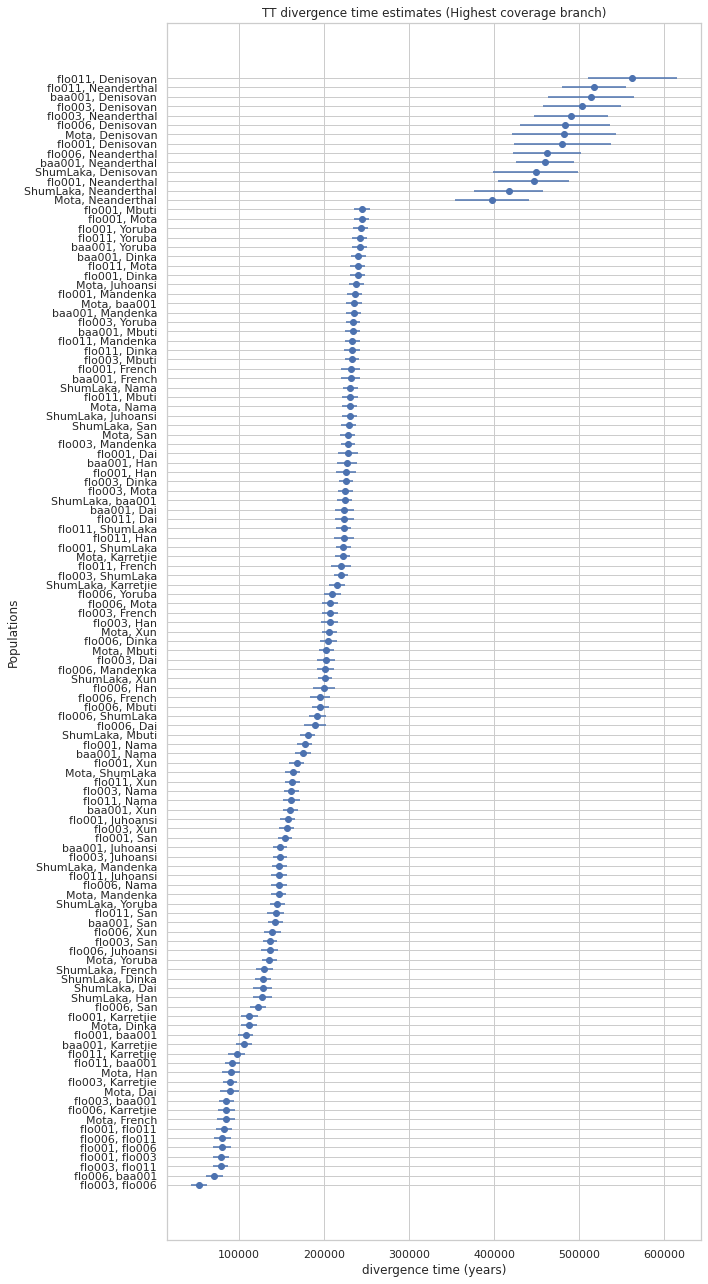

In [379]:
# Plot Ancient comparisons (corrected, and only higher coverage branch)
fig,ax = plt.subplots(1,1,figsize=(10,18))
a = df_ancients['HighCovBranch_wbjmeanT']
b = df_ancients['Populations']
#ax.scatter(a, b)
c = df_ancients['HighCovBranch_SE_T']
ax.errorbar(a, b, xerr=c, fmt='o')
ax.ticklabel_format(style='plain', axis='x')
ax.set_xlabel('divergence time (years)')
ax.set_ylabel('Populations')
ax.set_title('TT divergence time estimates (Highest coverage branch)')
plt.tight_layout()
if isSaveFigures:
    plt.savefig('figures/TT_mu_t_corrected_ancients.pdf')

In [380]:
mask_matjes = res_df_sorted['Populations'].apply(get_FilterMatjesPops)
df_matjes = res_df_sorted[mask_matjes]

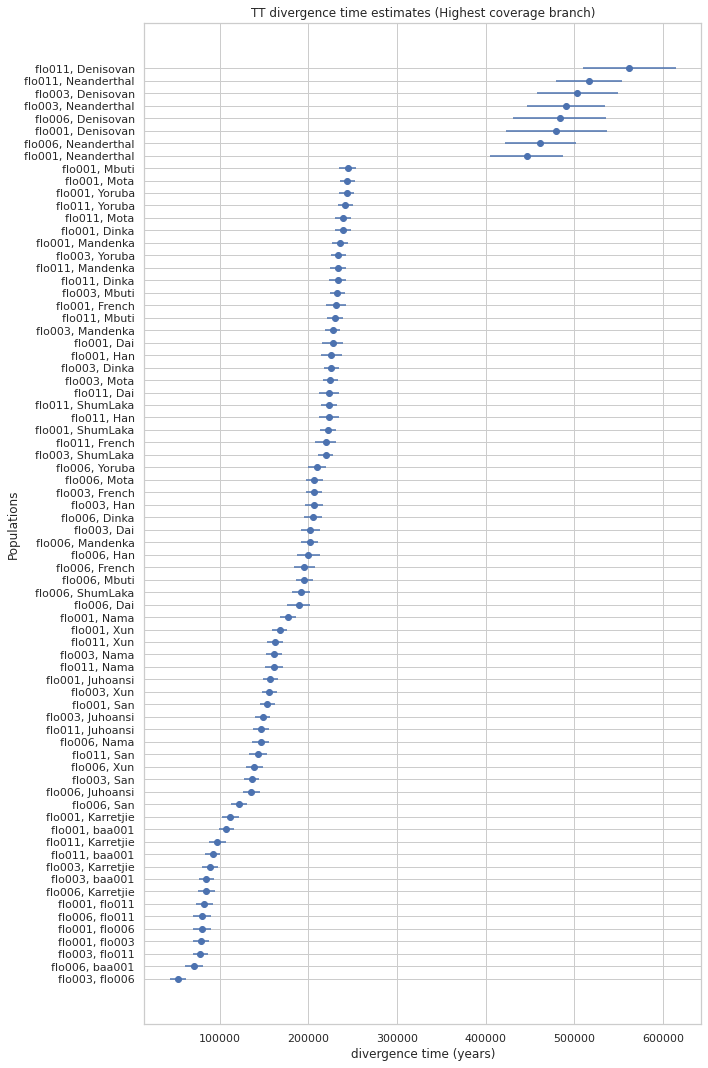

In [384]:
# Plot Matjes comparisons (corrected, and only higher coverage branch)
fig,ax = plt.subplots(1,1,figsize=(10,15))
a = df_matjes['HighCovBranch_wbjmeanT']
b = df_matjes['Populations']
c = df_matjes['HighCovBranch_SE_T']
ax.errorbar(a, b, xerr=c, fmt='o')
ax.ticklabel_format(style='plain', axis='x')
ax.set_xlabel('divergence time (years)')
ax.set_ylabel('Populations')
ax.set_title('TT divergence time estimates (Highest coverage branch)')
plt.tight_layout()
if isSaveFigures:
    plt.savefig('figures/TT_mu_t_corrected_matjes.pdf')

In [407]:
mask_moderns = res_df_sorted['Populations'].apply(get_FilterModernPops)
df_moderns = res_df_sorted[mask_moderns]

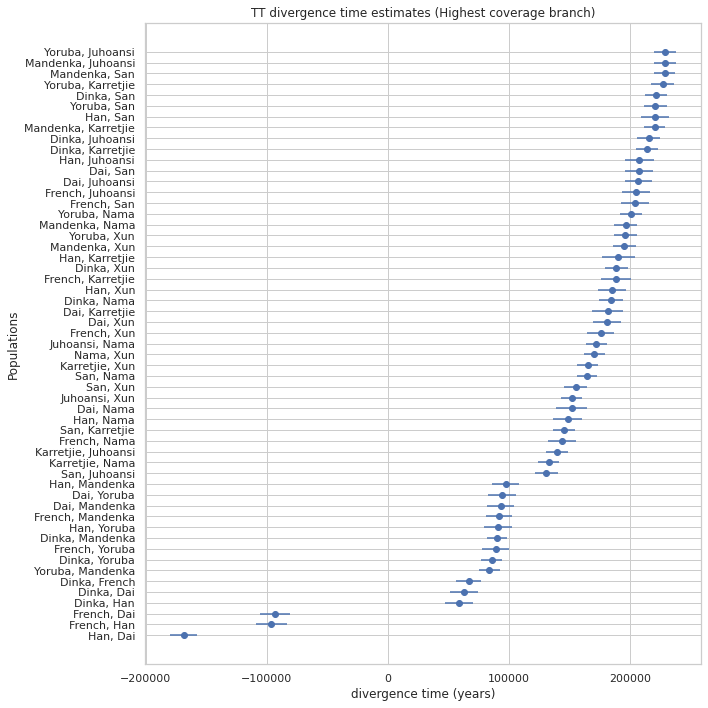

In [410]:
# Plot Matjes comparisons (corrected, and only higher coverage branch)
fig,ax = plt.subplots(1,1,figsize=(10,10))
a = df_moderns['HighCovBranch_wbjmeanT']
b = df_moderns['Populations']
c = df_moderns['HighCovBranch_SE_T']
ax.errorbar(a, b, xerr=c, fmt='o')
ax.ticklabel_format(style='plain', axis='x')
ax.set_xlabel('divergence time (years)')
ax.set_ylabel('Populations')
ax.set_title('TT divergence time estimates (Highest coverage branch)')
plt.tight_layout()
if isSaveFigures:
    plt.savefig('figures/TT_mu_t_corrected_moderns.pdf')

### ToDo:
Save some plots to show the difference in time estimates with and without correction
Only plot the branch with the higher coverage



In [ ]:
# 6) Tryout Per's idea of varying generation time until branch differences are minimized